# Chapter 4: Agentic RAG

**From Zero to Hero: Build a Retrieval-Augmented Generation from Scratch**

---

*Links:*
- *Read [Chapter 4 blog](https://medium.com/@marcharaoui/chapter-4-agentic-rag-0a7217b1e0d9)*
-*Code repository on [GitHub](https://github.com/marcharaoui/RAG-from-scratch/tree/main/chapter4)*

*Author:*

Marc Haraoui

[LinkedIn](https://www.linkedin.com/in/marc-haraoui/) | [GitHub](https://github.com/marcharaoui) | [X](https://x.com/marcharaoui) | [Hugging Face](https://huggingface.co/MarcHaraoui) | [Medium](https://medium.com/@marcharaoui)

---

Welcome to the Chapter 4 Notebook! 🎉

This notebook serves as a hands-on guide for building a simple agentic RAG pipeline, aligning with the concepts discussed in Chapter 4, as shown here:

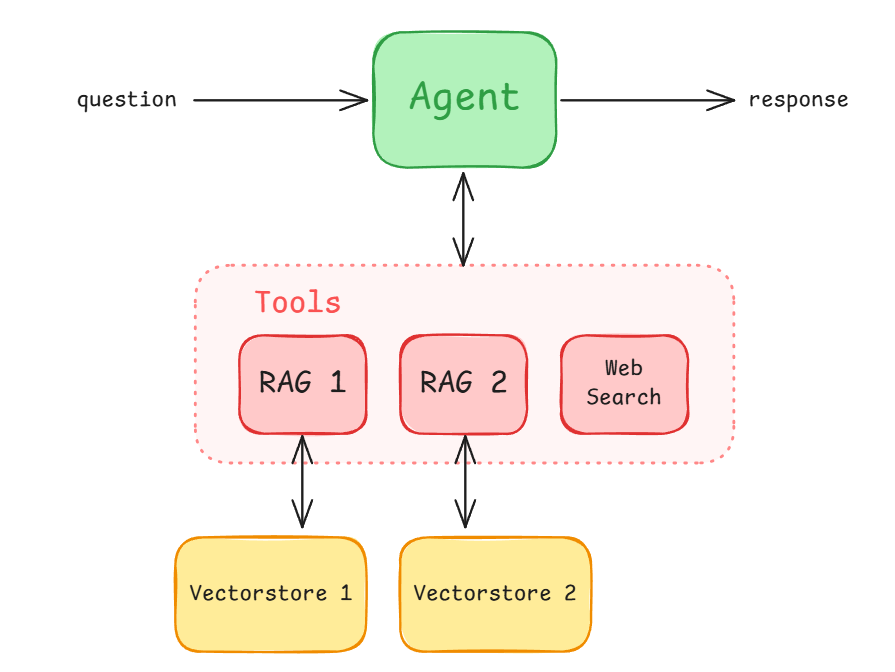

This notebook demonstrates a basic Agentic RAG pipeline, where a single agent (an LLM) reasons about your query, decides whether to use retrieval, dynamically writes queries, and processes results. The agent uses a simple vector knowledge base, an embedding model, and a language model from Hugging Face.

Let’s get started! Happy coding🚀

*P.S. this notebook could be updated and improved over time*

## Setup

Start by installing and importing the required packages.


In [1]:
!pip install smolagents langchain langchain-community langchain-huggingface scikit-learn rank_bm25 transformers --upgrade -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.0/134.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9

Import the libraries.

In [2]:
from langchain.docstore.document import Document
from langchain_community.retrievers import BM25Retriever
from langchain_huggingface import HuggingFaceEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
import numpy as np
from smolagents import Tool, ToolCallingAgent, CodeAgent, TransformersModel, InferenceClientModel
import transformers, langchain, sklearn

Versions used for this notebook:

```
Python 3.11.12
Numpy version 2.0.2
Transformers version 4.52.4
LangChain version 0.3.25
Scikit-learn version 1.6.1
```

Check yours:


In [3]:
!python --version
print(f"Numpy version {np.__version__}")
print(f"Transformers version {transformers.__version__}")
print(f"LangChain version {langchain.__version__}")
print(f"Scikit-learn version {sklearn.__version__}")

Python 3.11.12
Numpy version 2.0.2
Transformers version 4.52.4
LangChain version 0.3.25
Scikit-learn version 1.6.1


## Creating the Agentic RAG system

For this demo, we will code a minimal but powerful Agentic RAG class using a router-type agent. It supports routing between different retrieval methods (semantic, keyword, hybrid) and shows the agentic reasoning step-by-step.

This class is designed to be readable and easy to extend, so readers can quickly understand the core of agentic routing in RAG.

You can pick any embedding model or LLM with little to no code modification. The code uses Hugging Face open source models, so feel free to explore!






In [59]:
class RetrieverTool(Tool):
    """
    Single agent RAG pipeline (router) that routes to RAG when needed.
    It enables keyword or semantic retrieval and retrieve additional knowlede when needed .
    """
    name = "retriever"
    description = "Using similarity search, retrieves relevant documents from the knowledge base that have the closest meaning to the input query."
    inputs = {
        "query": {
            "type": "string",
            "description": "The question or search phrase. This should be as close as possible to your target documents. Use the affirmative form rather than a question.",
        }
    }
    output_type = "string"

    def __init__(self, docs, search="semantic", embedding_model_name="thenlper/gte-small", top_k=1):
        super().__init__()

        # Setup search technique
        self.search = search.lower()
        self.top_k = top_k
        self.docs = docs

        # Setup retriever
        if self.search == "keyword":
            self.retriever = BM25Retriever.from_documents(docs, k=top_k)
        elif self.search == "semantic":
            self.embedding_model = HuggingFaceEmbeddings(model_name=embedding_model_name)
            self.retriever = np.array(self.embedding_model.embed_documents([doc.page_content for doc in docs]))
        else:
          raise ValueError("Unsupported search method. Choose from 'keyword', and 'semantic'.")

    def forward(self, query: str) -> str:
        """ Perform similarity search and retrieve context based on the user's query."""
        if self.search == "keyword":
            retrieved_docs = self.retriever.invoke(query)
            return "\nRetrieved documents:\n".join(
                [f"\n===== Document {i+1} =====\n" + doc.page_content for i, doc in enumerate(retrieved_docs)]
            )
        elif self.search == "semantic":
            query_embedding = np.array(self.embedding_model.embed_query(query)).reshape(1, -1)
            similarities = cosine_similarity(query_embedding, self.retriever)[0]
            top_indices = np.argsort(similarities)[-self.top_k:][::-1]
            return "\nRetrieved documents:\n".join(
                [f"\n===== Document {i+1} =====\n" + self.docs[i].page_content for i in top_indices]
            )


## How to use

Indexing is an offline task, meaning it is done ahead of time. This allows you to quickly look up relevant information at query-time.

When the user sends a query, the goal is to retrieve relevant documents, combine them with the query and specific instructions, and have the VLM generate a tailored answer in natural language.


### Data Preparation
For this demo, we'll use a few AI-generated text documents.

In [55]:
wikipedia_text = "The sun is the star at the center of the Solar System. It provides energy through nuclear fusion and is essential for life on Earth."
html_ai_text   = "<h1>Artificial Intelligence</h1><p>AI refers to machines that can perform tasks requiring human intelligence, including learning, problem solving, and decision-making.</p>"
messi_text     = "Lionel Messi is widely regarded as one of the greatest footballers of all time. He has won numerous Ballon d'Or awards and set records for both club and country. Messi’s playing style combines incredible dribbling, vision, and goal-scoring ability."

documents = [
    Document(page_content=wikipedia_text, metadata={"id": "doc1", "name": "wikipedia_text.txt"}),
    Document(page_content=html_ai_text, metadata={"id": "doc2", "name": "html_ai_text.html"}),
    Document(page_content=messi_text, metadata={"id": "doc3", "name": "messi_text.txt"})
]

### Test the pipeline's response

Setup the retriever tool

In [60]:
embedding_model ="thenlper/gte-small"
retriever_tool = RetrieverTool(documents, search='keyword', embedding_model_name=embedding_model)

Setup the llm and the agent

In [61]:
# Set model name
# generator_model = 'Qwen/Qwen2.5-Coder-32B-Instruct'
generator_model = 'meta-llama/Llama-3.3-70B-Instruct'
# generator_model = "HuggingFaceTB/SmolLM2-360M-Instruct"

# Use a bigger model via Inference API on Hugging Face (free trial + cheap prices)
hf_token = "<insert_your_token>" # Create a hugging face token (select 'Read access to contents of all public gated repos you can access' and 'Make calls to Inference Providers')
model    = InferenceClientModel(model_id=generator_model, token=hf_token)

# Use a smaller model locally
# model = TransformersModel(model_id=generator_model)

# Initialize the agent
agent = ToolCallingAgent(tools=[retriever_tool], model=model)

Talk to the agent

In [62]:
question = "What is Messi’s playing style?"

agent_output = agent.run(question)

print("\nFinal answer:")
print(agent_output)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ What is Messi’s playing style?                                                                                  │
│                                                                                                                 │
╰─ InferenceClientModel - meta-llama/Llama-3.3-70B-Instruct ──────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'retriever' with arguments: {'query': 'Messi playing style'}                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Observations: ===== Document 1 =====
Lionel Messi is widely regarded as one of the greatest footballers of all time. He has won numerous Ballon d'Or 
awards and set records for both club and country. Messi’s playing style combines incredible dribbling, vision, and 
goal-scoring ability.

[Step 1: Duration 0.47 seconds| Input tokens: 1,193 | Output tokens: 21]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'final_answer' with arguments: {'answer': 'Incredible dribbling, vision, and goal-scoring         │
│ ability'}                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final answer: Incredible dribbling, vision, and goal-scoring ability

[Step 2: Duration 1.41 seconds| Input tokens: 2,536 | Output tokens: 49]


Final answer:
Incredible dribbling, vision, and goal-scoring ability


And there you have it, a functional Agentic router for RAG purposes at your disposal! This is just the beginning of what you can do with agents, you can learn more about this:
- Full Agentic RAG explanation: https://huggingface.co/learn/cookbook/agent_rag
- Multi-agent RAG: https://huggingface.co/learn/cookbook/multiagent_rag_system


You can expand this with more retrieval methods, bigger knowledge bases, better models, and additional agents for richer and more complex reasoning. Feel free to explore how to build more agents using the [smolagents documentation](https://huggingface.co/docs/smolagents/index).🤗